In [57]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import mprompt.data.data
from mprompt.data.data import TASKS_D3
import mprompt.methods.m4_evaluate as m4_evaluate
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename='01_explain.py')

100%|██████████| 76/76 [00:06<00:00, 11.15it/s]


In [50]:
# rdel = r[r.module_num.isin([11, 18, 1, 31, 46])]
# imodelsx.process_results.delete_runs_in_dataframe(rdel, actually_delete=True)

In [64]:
# metadata
r['task_str'] = r.apply(lambda row: mprompt.data.data.get_task_str(row['module_name'], row['module_num']), axis=1)
r['task_keyword'] = r['task_str'].apply(lambda task_str: mprompt.data.data.get_task_keyword(task_str))
r['task_name (groundtruth)'] = r['task_str'].apply(lambda s: s.split('_')[-1])
r['ngrams_restricted'] = ~(r['module_num_restrict'] == -1)

# recompute score_contains_keywords
r['score_contains_keywords'] = r.apply(lambda row: m4_evaluate.compute_recovery_metrics(row, row['explanation_init_strs']), axis=1)

# metrics (derived from score_contains_keywords)
r['top_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: int(x[0]))
r['mean_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: np.mean(x))
r['any_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: int(np.max(x)))
r['num_generated_explanations'] = r['score_contains_keywords'].apply(lambda x: len(x))
r[f'mean_contains_keywords_weighted'] = r[f'mean_contains_keywords'] * r['num_generated_explanations']
r['row_count_helper'] = 1

# simplifying
r = r.sort_values(by='top_score_synthetic', ascending=False).round(3)
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

In [65]:
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    d = (
        rd[[
            'task_keyword', 'top_explanation_init_strs',
            'top_contains_keywords', #        'mean_contains_keywords',
            'top_score_synthetic', 'module_num'
        ]]
        .rename(columns={
            'task_keyword': 'GT Explanation',
            'top_explanation_init_strs': 'Generated Explanation',
        })
    )
    d_ = d[d.top_contains_keywords == 0]
    slice_ = pd.IndexSlice[d_.index, d_.columns]

    # s = d.style
    display(
        d
        .style.hide()
        .set_properties(**{'background-color': '#132639'}, subset=slice_)
        .format(precision=2)
   )
    

GT Explanation,Generated Explanation,top_contains_keywords,top_score_synthetic,module_num
Hillary,name hillary or hillary clinton,1,0.53,17
evacuation,"concept of evacuation, or the process of leaving a place in an emergency situation",1,0.47,5
abortion,topic of abortion,1,0.40,21
pro-life,discussion of abortion and the related topics of pro-life and pro-choice,1,0.40,20
politics,politics,1,0.35,53
physics,physics,1,0.33,22
Hillary,hillary or hillary clinton,1,0.32,16
atheistic,"atheism and related topics, such as theism, religious beliefs, and atheists",1,0.30,4
utility,letter u or the word utilization or utility,1,0.30,15
toxic,idea of danger and toxicity,1,0.29,19


### Explanation recovery accuracy results

In [66]:
r = r[r['module_num'] < 22]

In [67]:
groupings = ['noise_ngram_scores', 'ngrams_restricted']
metrics = ['any_contains_keywords', 'top_contains_keywords', 'mean_contains_keywords']
metrics_weighted = ['mean_contains_keywords_weighted']
helpers = ['row_count_helper', 'num_generated_explanations']
index_remap = {
    (0.0, False): 'Default',
    (0.0,  True): '+Ngram restriction',
    (3.0, False): '+Module noise',
}

g = (
    r
    .filter(groupings + metrics + metrics_weighted + helpers)
    .groupby(groupings)
    .sum()
    .sort_values(by='any_contains_keywords', ascending=False)
)
for met in metrics:
    g[met] = g[met] / g['row_count_helper']
for met in metrics_weighted:
    g[met] = g[met] / g['num_generated_explanations']
g = g.rename(
    columns={
        'any_contains_keywords': 'Recall @ 5',
        'top_contains_keywords': 'Recall @ 1',
        'mean_contains_keywords_weighted': 'Recall @ 1 (w/out synthetic ranking)',
        'mean_contains_keywords': 'Recall @ 1 (w/out synthetic, unweighted)',
    }
).round(3).drop(columns=helpers + ['Recall @ 1 (w/out synthetic, unweighted)'])

g.index = [index_remap[x] for x in g.index.values]
display(g)

,Recall @ 5,Recall @ 1,Recall @ 1 (w/out synthetic ranking)
Default,0.947,0.947,0.860
+Module noise,0.789,0.737,0.500
+Ngram restriction,0.769,0.769,0.667


### Does synthetic score help explanation recovery?

In [13]:
groupings = ['noise_ngram_scores', 'ngrams_restricted', 'top_contains_keywords']
metrics = ['top_score_synthetic']
g2 = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .pivot_table(index=['noise_ngram_scores', 'ngrams_restricted'],
                 columns='top_contains_keywords',
                 values='top_score_synthetic')
    .rename_axis(None, axis=1)  
    .rename(columns={
    True: 'Synthetic score (correct)',
    False: 'Synthetic score (incorrect)',
    })
)
g2.index = [index_remap[x] for x in g2.index.values]
display(g2)

,Synthetic score (incorrect),Synthetic score (correct)
Default,0.148,0.243
+Ngram restriction,0.111,0.222
+Module noise,0.088,0.283


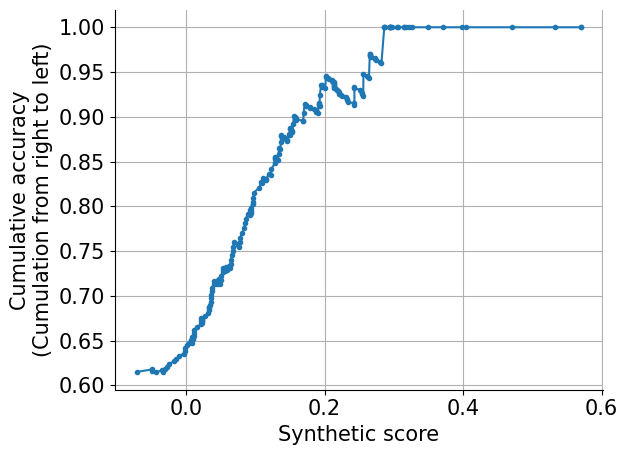

In [14]:
# compute corrects
scores_synth = sum(r.score_synthetic.values, [])
corrects = sum(r.score_contains_keywords.values, [])
args = np.argsort(scores_synth)[::-1] # high to low
scores_synth = np.array(scores_synth)[args]
corrects = np.array(corrects)[args]

# plot
plt.plot(scores_synth, np.cumsum(corrects) / np.arange(1, len(corrects) + 1), '.-')
plt.ylabel('Cumulative accuracy\n(Cumulation from right to left)')
plt.xlabel('Synthetic score')
plt.grid()
plt.show()

# Details

In [ ]:
# display full strings
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )